### Putting all together

In [103]:
import torch
from torch import nn
import matplotlib.pyplot as plt

print(torch.__version__)

2.4.1+cu121


In [104]:
# device agnostic code
# if we got gpu use it

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [105]:
## Getting data ready
## using linear regression formula

weight = 0.7
bias = 0.3

X = torch.arange(0,1,0.02).unsqueeze(dim=1)
y = weight * X + bias

X[:10]

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

In [106]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [107]:
## Plot the data

def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  plt.figure(figsize=(9,7))
  plt.scatter(train_data, train_labels, c="b", s=9, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=9, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=9, label="Predictions")
  plt.legend(prop={"size":14})
  plt.show()

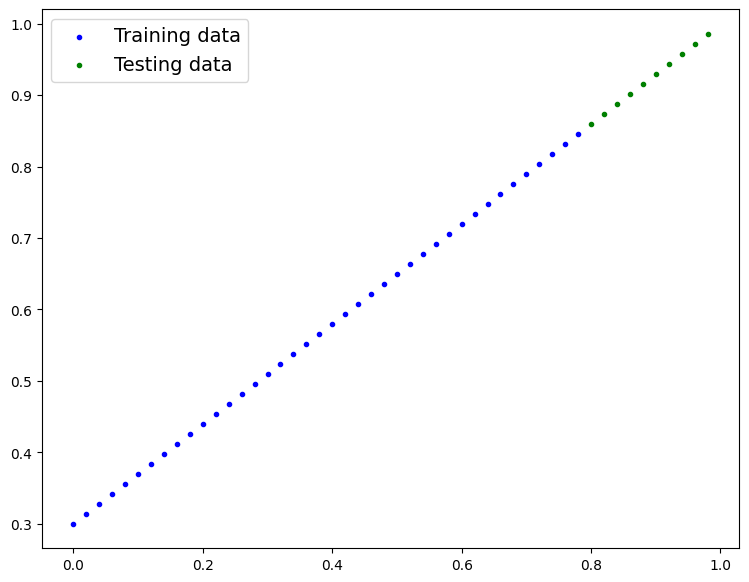

In [108]:
plot_predictions()

In [109]:
## Building a Linear Model

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(1))
    self.bias = nn.Parameter(torch.rand(1))

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.weight * X + self.bias

In [110]:
## use linear model
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # y = ax + b
    self.linear_layer = nn.Linear(in_features=1, # X
                                  out_features=1) # y

  # defining method
  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(X)

# manual seed
model_1 = LinearRegressionModel()
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.2742]])),
              ('linear_layer.bias', tensor([-0.0511]))]))

In [111]:
## set the model to use the target device

next(model_1.parameters()).device

device(type='cpu')

In [112]:
model_1.to(device)
next(model_1.parameters()).device # gpu if gpu

device(type='cpu')

In [113]:
## Training

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.001)

epochs = 900
epoch_count = []
train_loss_value = []
test_loss_value = []

# put data on target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

torch.manual_seed(2)

for epoch in range(epochs):
  model_1.train() # forward pass model
  y_pred = model_1(X_train) # get the output
  train_loss = loss_fn(y_pred, y_train) # calculate the loss
  optimizer.zero_grad() # zero the optimzer
  train_loss.backward() # backprogation
  optimizer.step() # update the weight and bias
  model_1.eval() # turn off grad and any other optimizer

  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_value.append(train_loss)
    test_loss_value.append(test_loss)
    print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")

Epoch: 0 | Train Loss: 0.517128586769104 | Test Loss: 0.7286672592163086
Epoch: 10 | Train Loss: 0.5056077241897583 | Test Loss: 0.7151963114738464
Epoch: 20 | Train Loss: 0.49408674240112305 | Test Loss: 0.7017253637313843
Epoch: 30 | Train Loss: 0.4825657904148102 | Test Loss: 0.6882544755935669
Epoch: 40 | Train Loss: 0.47104477882385254 | Test Loss: 0.67478346824646
Epoch: 50 | Train Loss: 0.4595238268375397 | Test Loss: 0.6613125801086426
Epoch: 60 | Train Loss: 0.4480028748512268 | Test Loss: 0.6478416323661804
Epoch: 70 | Train Loss: 0.43648186326026917 | Test Loss: 0.6343706846237183
Epoch: 80 | Train Loss: 0.4249609112739563 | Test Loss: 0.6208997368812561
Epoch: 90 | Train Loss: 0.41343992948532104 | Test Loss: 0.6074287295341492
Epoch: 100 | Train Loss: 0.4019189774990082 | Test Loss: 0.5939578413963318
Epoch: 110 | Train Loss: 0.39039796590805054 | Test Loss: 0.5804869532585144
Epoch: 120 | Train Loss: 0.37887704372406006 | Test Loss: 0.5670160055160522
Epoch: 130 | Train L

In [114]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5378]])),
             ('linear_layer.bias', tensor([0.3681]))])

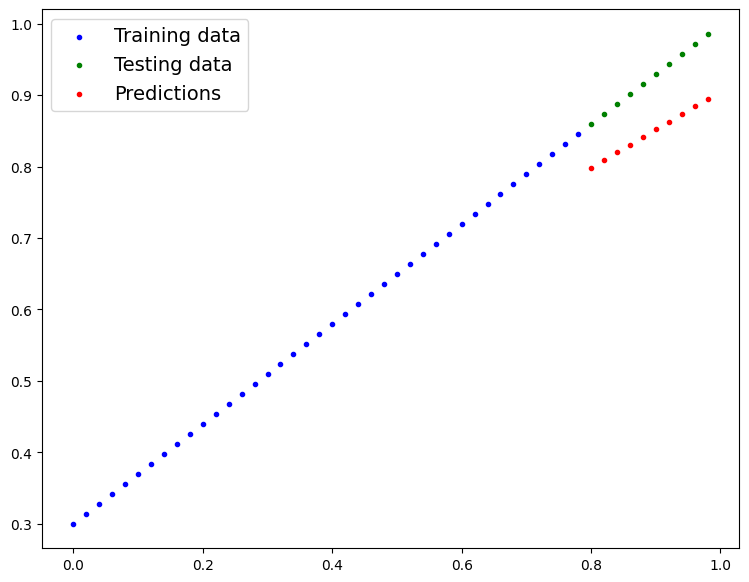

In [115]:
# evaluating mode
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)

plot_predictions(predictions=y_preds)

In [116]:
# saving the model

torch.save(obj=model_1.state_dict(), f="./01_pytorch.pt")

In [117]:
loaded_model_1 = LinearRegressionModel()
loaded_model_1.load_state_dict(torch.load("./01_pytorch.pt"))

<ipython-input-117-486e9cf586c9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load("./01_pytorch.pt"))


<All keys matched successfully>

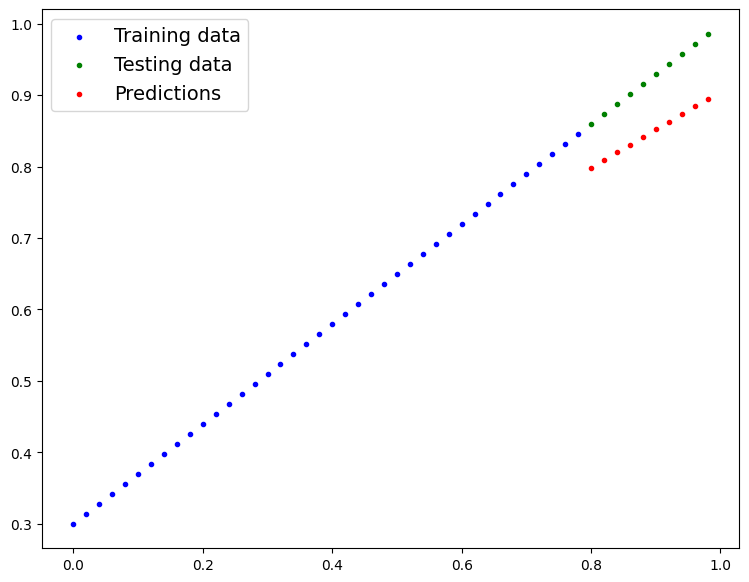

In [118]:
with torch.inference_mode():
  y_preds = loaded_model_1(X_test)

plot_predictions(predictions=y_preds)

In [120]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [119]:
loaded_model_1.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [121]:
next(loaded_model_1.parameters()).device

device(type='cpu')